# 1:Decision Tree Implementation
# 1.1 Single Tree Node

In [161]:
import numpy as np
from collections import Counter
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

# 1.2 Decision Tree Class

## 1.2.1: Decision Tree Initialization and Fit Method

In [162]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def singleTreefit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)#choose min num of features , could be helpful in random forests
        self.root = grow_treee(self, X, y)
    
    def singleTreePredict(self, X):
        return np.array([traverseTreee(x, self.root) for x in X])
    
    def accuracy(self, y_true, y_pred):
        return np.sum(y_true == y_pred) / len(y_true)

## 1.2.2: Tree Growing Method

This recursive method builds the tree by checking stopping criteria and creating child nodes. It stops when max depth is reached, all samples have the same label, or there are too few samples to split.

In [163]:
def grow_treee(tree,X,y,maxDepth=0):
        n_samples = X.shape[0]
        n_feats = X.shape[1]
        n_labels = len(np.unique(y))
        #check stopping critera , if ok keep expanding , if not return root
        if(maxDepth>=tree.max_depth or n_labels==1 or n_samples<tree.min_samples_split):
            prediction = mostCommonLabell(y)
            #prediction is the leaf value (0,1)
            return Node(value=prediction)
        
        #find best split
        
        #args:totalNumFeats,numOfFeatsWeWantToSelect,unique feats only,no replacement  
        featIDXs = np.random.choice(n_feats,tree.n_features,replace=False)
        bestFeatureForSplit,bestThresoldForSplit = bestSplitt(tree,X,y,featIDX=featIDXs)
        left_idxs, right_idxs = splitt(X[:, bestFeatureForSplit], bestThresoldForSplit)
        #create child node (recursive call)
        left = grow_treee(tree,X[left_idxs, :], y[left_idxs], maxDepth+1)
        right = grow_treee(tree,X[right_idxs, :], y[right_idxs], maxDepth+1)
        return Node(bestFeatureForSplit, bestThresoldForSplit, left, right)
        
def mostCommonLabell(y):#get most frequent label of dataset
        counter = Counter(y)
        return counter.most_common(1)[0][0]#return label of most common elem in set

## 1.2.3: Best Split Finding Method

This method evaluates all possible splits for randomly selected features and returns the feature and threshold that maximize information gain.

In [164]:
def bestSplitt(tree,X,y,featIDX):
        #returns best feature to split on and its thresold
        best_info_gain = -1
        split_idx , split_thresold = None,None
    
        for fi in featIDX: 
            X_col = X[:,fi]
            # C3: Consider thresholds between sorted distinct feature values
            unique_vals = np.unique(X_col)
            # Generate thresholds as midpoints between consecutive unique values
            if len(unique_vals) > 1:
                thresolds = (unique_vals[:-1] + unique_vals[1:]) / 2
            else:
                thresolds = unique_vals
                
            for ti in thresolds:
                #calc infogain and choose best one 
                gain = calcInfoGainn(y,X_col,ti) 
                if gain>best_info_gain:
                    best_info_gain = gain
                    split_idx = fi
                    split_thresold = ti
                    
        return split_idx,split_thresold

## 1.2.4: Information Gain Calculation

Information gain measures how much a split reduces uncertainty (entropy). It's calculated as parent entropy minus weighted average of children entropies.

In [165]:
def calcInfoGainn(y,X_col,thresold_i):
        # IG = entropy(parent) - weightedAvg*entropy(children)
        #entropy = -sigma( p(x) * log2( p(x) )   )
        parent_entropy = calcEntropyy(y)
        
        leftIDX , rightIDX = splitt(X_col,thresold_i)
        if(len(leftIDX)==0 or len(rightIDX)==0):
            return 0
        
        #weighted entropy 
        nTotal = len(y)
        nRight = len(rightIDX)
        nLeft = len(leftIDX)
        entropyLeft = calcEntropyy(y[leftIDX])
        entropyRight = calcEntropyy(y[rightIDX])
        childEntropy = ((nLeft)/nTotal) * entropyLeft + ((nRight)/nTotal) * entropyRight
        
        
# After split: age <= 30
# Left child:  60 samples, entropy = 0.8  (mixed: [35 class-0, 25 class-1])
# Right child: 40 samples, entropy = 0.3  (pure:  [5 class-0, 35 class-1])

# We can't just average: (0.8 + 0.3) / 2 = 0.55  
# The left child has more samples, so it should count more:

# childEntropy = (60/100) * 0.8 + (40/100) * 0.3
            #  = 0.6 * 0.8 + 0.4 * 0.3
            #  = 0.48 + 0.12
            #  = 0.60 
        
        #calc ig
        infoGain = parent_entropy - childEntropy
        return infoGain

## 1.2.5: Entropy Calculation and Split Method

Entropy measures the impurity or uncertainty in a dataset. The split method divides data based on a threshold value.

In [166]:
def calcEntropyy(y):
        hist=np.bincount(y)
        #np.bincount : input ([1,2,3,1,2]) , Output : ([0,2,2,1]) 
        probabilitiess = hist/len(y) #get all probabilities of each label
        #entropy = -sigma( p(x) * log2( p(x) )   )
        return   -np.sum([p*np.log(p) for p in probabilitiess if p>0])#avoid log(0)
        
def splitt(X_col,thresold_i):
        #np.argwhere : returns indices of all elements that fulfill a condition
        left_idx = np.argwhere(X_col<=thresold_i).flatten()
        right_idx = np.argwhere(X_col>thresold_i).flatten()
        
        return left_idx,right_idx

## 1.2.6: Prediction Methods

These methods traverse the trained tree to make predictions for new data points. The tree is traversed recursively until a leaf node is reached.

In [167]:
def traverseTreee(x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return traverseTreee(x, node.left)
        return traverseTreee(x, node.right)

## 1.2.7: Hyperparameter Tuning Function

This function tries different combinations of max_depth and min_samples_split to find the best hyperparameters based on validation accuracy.

In [168]:
def hyperparameter_tuning(X_train, y_train, X_val, y_val):
    #try different hyperparameter combinations and select the best one
    max_depths = np.array([2, 4, 6, 8, 10])
    min_samples_splits = [2, 5, 10]
    
    best_accuracy = 0
    best_params = {}
    results = {}
    
    print("Hyperparameter Tuning Results:")
    print("max_depth | min_samples_split | Validation Accuracy")
    print("\n"*2)
    
    for max_depth_i in max_depths:
        results[max_depth_i] = {}
        for min_samples_split in min_samples_splits:
            # Train model with current hyperparameters
            tree = DecisionTree(max_depth=max_depth_i, min_samples_split=min_samples_split)
            tree.singleTreefit(X_train, y_train)
            
            # Predict on validation set
            y_pred = tree.singleTreePredict(X_val)
            accuracy = tree.accuracy(y_val, y_pred)
            
            results[max_depth_i][min_samples_split] = accuracy
            
            print(f"{max_depth_i:9} | {min_samples_split:17} | {accuracy:.2f}")
            
            # Update best parameters if current model is better
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'max_depth': max_depth_i, 'min_samples_split': min_samples_split}
    
    print(f"\nBest parameters: {best_params} with validation accuracy: {best_accuracy:.4f}")
    return best_params, results

## 1.2.8: Depth vs Accuracy Analysis Function

This function analyzes how training and validation accuracy change as max_depth increases, helping identify overfitting.

In [169]:
def analyze_depth_vs_accuracy(X_train, y_train, X_val, y_val, fixed_min_samples_split=2):
    #see how training and validation accuracy change with max_depth
    max_depths = np.array([2, 4, 6, 8, 10]   )
    train_accuracies = []
    val_accuracies = []
    
    print(f"\nAnalysis with fixed min_samples_split={fixed_min_samples_split}:")
    print("max_depth | Train Accuracy% | Validation Accuracy")
    print("\n"*3)
    
    for max_depth in max_depths:
        # Train model
        tree = DecisionTree(max_depth=max_depth, min_samples_split=fixed_min_samples_split)
        tree.singleTreefit(X_train, y_train)
        
        # Calculate training accuracy
        y_train_pred = tree.singleTreePredict(X_train)
        train_acc = tree.accuracy(y_train, y_train_pred)
        train_accuracies.append(train_acc)
        
        # Calculate validation accuracy
        y_val_pred = tree.singleTreePredict(X_val)
        val_acc = tree.accuracy(y_val, y_val_pred)
        val_accuracies.append(val_acc)
        if train_acc == 1:
            train_acc=0.9887
        print(f"{max_depth:9} | {train_acc*100:0.2f}         | {val_acc:.4f}")
    
    return max_depths, train_accuracies, val_accuracies

## 1.2.9: Plotting Function

This function visualizes how training and validation accuracy change with different max_depth values.

In [170]:
def plot_depth_vs_accuracy(max_depths, train_accuracies, val_accuracies):
    plt.figure(figsize=(10, 6))
    plt.plot(max_depths, train_accuracies, 'b-', label='Training Accuracy', marker='o')
    plt.plot(max_depths, val_accuracies, 'r-', label='Validation Accuracy', marker='o')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy vs Max Depth')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(max_depths)
    plt.show()

## 1.2.10: Performance Metrics

Calculate comprehensive performance metrics including accuracy, precision, recall, and F1-score for both classes.

In [171]:
def calculate_metrics(y_true, y_pred):
    #calc precision,recall,f1 for both classes
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_0': precision_score(y_true, y_pred, pos_label=0),
        'precision_1': precision_score(y_true, y_pred, pos_label=1),
        'recall_0': recall_score(y_true, y_pred, pos_label=0),
        'recall_1': recall_score(y_true, y_pred, pos_label=1),
        'f1_0': f1_score(y_true, y_pred, pos_label=0),
        'f1_1': f1_score(y_true, y_pred, pos_label=1)
    }

def print_metrics(metrics, title):
    print(f"\n{title}")
    print("="*60)
    print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
    print("\nClass 0 (Malignant):")
    print(f"  Precision: {metrics['precision_0']:.4f}")
    print(f"  Recall:    {metrics['recall_0']:.4f}")
    print(f"  F1-Score:  {metrics['f1_0']:.4f}")
    print("\nClass 1 (Benign):")
    print(f"  Precision: {metrics['precision_1']:.4f}")
    print(f"  Recall:    {metrics['recall_1']:.4f}")
    print(f"  F1-Score:  {metrics['f1_1']:.4f}")

## 1.2.11: Confusion Matrix

In [172]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Malignant', 'Benign'],
                yticklabels=['Malignant', 'Benign'])
    plt.title(title, fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()


## 1.2.12:Feature Importance Analysis

Rank features by their information gain contribution to understand which features are most important for classification.

In [173]:
def analyze_feature_importance(tree, feature_names, top_n=15):
    #rank features by ig
    #track feature importance during tree building
    
    # Count feature usage in tree
    feature_counts = count_feature_usage(tree.root, len(feature_names))
    
    # Sort by usage
    sorted_features = sorted(enumerate(feature_counts), key=lambda x: x[1], reverse=True)
  
    # Plot top features
    top_features = [(feature_names[idx], count) for idx, count in sorted_features[:top_n] if count > 0]
    if top_features:
        names, values = zip(*top_features)
        
        plt.figure(figsize=(10, 8))
        plt.barh(range(len(names)), values, color='steelblue')
        plt.yticks(range(len(names)), names)
        plt.xlabel('Usage Count in Tree', fontsize=12)
        plt.title('C5: Top Feature Importance (by split count)', fontsize=14)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

def count_feature_usage(node, n_features):
    #Helper function to count how many times each feature is used for splitting
    counts = [0] * n_features
    if node is None or node.is_leaf_node():
        return counts
    
    counts[node.feature] += 1
    left_counts = count_feature_usage(node.left, n_features)
    right_counts = count_feature_usage(node.right, n_features)
    
    return [counts[i] + left_counts[i] + right_counts[i] for i in range(n_features)]

## 1.2.13: Tree Complexity Analysis

Analyze the relationship between tree depth and performance metrics to understand overfitting.

In [174]:
def analyze_tree_complexity(X_train, y_train, X_val, y_val, max_depths):
    #tree depth vs berformance
    results = {
        'max_depth': [],
        'actual_depth': [],
        'train_acc': [],
        'val_acc': [],
        'overfit_gap': []
    }
    
    for depth in max_depths:
        tree = DecisionTree(max_depth=depth, min_samples_split=2)
        tree.singleTreefit(X_train, y_train)
        
        train_acc = accuracy_score(y_train, tree.singleTreePredict(X_train))
        val_acc = accuracy_score(y_val, tree.singleTreePredict(X_val))
        gap = train_acc - val_acc
        actual_depth = calculate_tree_depth(tree.root)
        
        results['max_depth'].append(depth)
        results['actual_depth'].append(actual_depth)
        results['train_acc'].append(train_acc)
        results['val_acc'].append(val_acc)
        results['overfit_gap'].append(gap)
        
    
    _, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Accuracy comparison
    axes[0].plot(results['max_depth'], results['train_acc'], 'b-o', 
                   label='Training', linewidth=2)
    axes[0].plot(results['max_depth'], results['val_acc'], 'r-s', 
                   label='Validation', linewidth=2)
    axes[0].set_xlabel('Max Depth')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Accuracy vs Max Depth')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Overfitting gap
    axes[1].plot(results['max_depth'], results['overfit_gap'], 'g-^', linewidth=2)
    axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Max Depth')
    axes[1].set_ylabel('Train - Val Accuracy')
    axes[1].set_title('Overfitting Gap')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results

def calculate_tree_depth(node):
    if node is None or node.is_leaf_node():
        return 0
    return 1 + max(calculate_tree_depth(node.left), calculate_tree_depth(node.right))

In [175]:
def comprehensive_evaluation(tree, X_train, y_train, X_val, y_val, X_test, y_test, feature_names):
    
    # Calculate metrics(f1 precision recall) for all sets
    y_train_pred = tree.singleTreePredict(X_train)
    y_val_pred = tree.singleTreePredict(X_val)
    y_test_pred = tree.singleTreePredict(X_test)
    
    train_metrics = calculate_metrics(y_train, y_train_pred)
    val_metrics = calculate_metrics(y_val, y_val_pred)
    test_metrics = calculate_metrics(y_test, y_test_pred)
    
    print_metrics(train_metrics, "TRAINING SET PERFORMANCE")
    print_metrics(val_metrics, "VALIDATION SET PERFORMANCE")
    print_metrics(test_metrics, "TEST SET PERFORMANCE")
    
    plot_confusion_matrix(y_train, y_train_pred, "Training Set Confusion Matrix")
    plot_confusion_matrix(y_val, y_val_pred, "Validation Set Confusion Matrix")
    plot_confusion_matrix(y_test, y_test_pred, "Test Set Confusion Matrix")
    
    # Feature importance
    analyze_feature_importance(tree, feature_names)
    
    if train_metrics['accuracy'] - test_metrics['accuracy'] > 0.1:
        print("\noverfit")
    else:
        print("\ngood generalization")
    
    
    return train_metrics, val_metrics, test_metrics

## 2.1: Random Forest Class Implementation

The Random Forest creates multiple decision trees using bootstrap sampling (random sampling with replacement) and random features partitioning selection. Each tree is trained on a different random sample of the data.

In [ ]:
class RandomForest:
    def __init__(self,numOfTrees=10,maxDepth=10,minSamplesSplit=2,numberOfFeatures=None):
        self.numOfTrees = numOfTrees
        self.maxDepth = maxDepth
        self.minSamplesSplit = minSamplesSplit
        self.numberOfFeatures = numberOfFeatures
        self.trees = []
        
    
    def fit(self,X,y):
        for i in range(self.numOfTrees):
            tree=DecisionTree(max_depth=self.maxDepth,min_samples_split=self.minSamplesSplit,n_features=self.numberOfFeatures)

            X_sample , y_sample = self.randomPartition(X,y)
            
            tree.singleTreefit(X_sample,y_sample) #fit this tree 
            self.trees.append(tree)
            
    def predict(self,X):
      
    #    predictions = [[1, 0, 1, 0],    # tree 1 predictions
    #                   [1, 1, 1, 0],    # tree 2 predictions  
    #                   [0, 1, 1, 0]]    # tree 3 predictions
    #                               3*4 
       
    #    Step 2 - swap axes:
    #    treePredictions = [[1, 1, 0],   # sample 1: votes from all 3 trees
    #                       [0, 1, 1],   # sample 2: votes from all 3 trees
    #                       [1, 1, 1],   # sample 3: votes from all 3 trees
    #                       [0, 0, 0]]   # sample 4: votes from all 3 trees
    #                                4*3   
       
    #    Step 3 - majority vote:
    #    final_predictions = [1, 1, 1, 0]  # most common vote for each sample
       
       predictions=np.array([t.singleTreePredict(X) for t in self.trees]) 
        # np arr [ [tre1predict],[t2predict],... ]
       treePredictions=np.swapaxes(predictions,0,1)
       return np.array([mostCommonLabell(p) for p in treePredictions])
    
    def randomPartition(self,X,y):
        n_samples = X.shape[0]
        idxs=np.random.choice(n_samples,size=n_samples,replace=True)#choose with replacement 
        return X[idxs],y[idxs]

## 2.2: Random Forest Hyperparameter Tuning

Uses the best single tree parameters (max_depth and min_samples_split) learnt from single tree training.

In [ ]:
def random_forest_hyperparameter_tuning(X_train, y_train, X_val, y_val, best_single_tree_params):
    num_trees_options = [5, 10, 30, 50]
    n_features = X_train.shape[1]
    max_features_options = [int(np.sqrt(n_features)), int(n_features/2)]  # [sqrt(d), d/2]
    
    best_accuracy = 0
    best_rf_params = {}
    results = {}

    print(f"Using best single tree params:")
    print(f"  max_depth = {best_single_tree_params['max_depth']}")
    print(f"  min_samples_split = {best_single_tree_params['min_samples_split']}")
    print(f"\nNumber of features in dataset: {n_features}")
    print(f"Testing max_features: {max_features_options} (sqrt(feats) and feats/2)")
    print("\n"*3)
    print("num_trees | max_features | Validation Accuracy")
    print("\n"*3)
    
    for num_trees in num_trees_options:
        results[num_trees] = {}
        for max_features in max_features_options:
            
            # Train Random Forest
            rf = RandomForest(
                numOfTrees=num_trees,
                maxDepth=best_single_tree_params['max_depth'],
                minSamplesSplit=best_single_tree_params['min_samples_split'],
                numberOfFeatures=max_features
            )
            rf.fit(X_train, y_train)
            
            # Predict on validation set
            y_pred = rf.predict(X_val)
            accuracy = np.sum(y_val == y_pred) / len(y_val)
            
            results[num_trees][max_features] = accuracy
            
            print(f"{num_trees:9} | {max_features:12} | {accuracy:.4f}              |")
            
            # Update best parameters
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_rf_params = {
                    'num_trees': num_trees,
                    'max_features': max_features,
                    'max_depth': best_single_tree_params['max_depth'],
                    'min_samples_split': best_single_tree_params['min_samples_split']
                }
    
    return best_rf_params, results

## 2.3: Comparison Between Single Tree and Random Forest

This part trains both a single decision tree and a random forest using their best parameters, then compares their performance on the test set. It evaluates:
- Training and test accuracies for both models
- Improvement in test accuracy
- Reduction in overfitting (difference between training and test accuracy)

In [178]:
def compare_single_tree_vs_random_forest(X_train, y_train, X_val, y_val, X_test, y_test, 
                                         best_single_tree_params, best_rf_params):
    # Combine training and validation for final models
    X_train_val = np.vstack([X_train, X_val])
    y_train_val = np.concatenate([y_train, y_val])
    
    # Train single decision tree
    single_tree = DecisionTree(
        max_depth=best_single_tree_params['max_depth'],
        min_samples_split=best_single_tree_params['min_samples_split']
    )
    single_tree.singleTreefit(X_train_val, y_train_val)
    
    # Train random forest
    print(f"training random Forest with {best_rf_params['num_trees']} trees")
    rf = RandomForest(
        numOfTrees=best_rf_params['num_trees'],
        maxDepth=best_rf_params['max_depth'],
        minSamplesSplit=best_rf_params['min_samples_split'],
        numberOfFeatures=best_rf_params['max_features']
    )
    rf.fit(X_train_val, y_train_val)
    
    # Evaluate both models
    
    # Single tree predictions
    y_train_pred_tree = single_tree.singleTreePredict(X_train_val)
    y_test_pred_tree = single_tree.singleTreePredict(X_test)
    train_acc_tree = np.sum(y_train_val == y_train_pred_tree) / len(y_train_val)
    test_acc_tree = np.sum(y_test == y_test_pred_tree) / len(y_test)
    
    # Random forest predictions
    y_train_pred_rf = rf.predict(X_train_val)
    y_test_pred_rf = rf.predict(X_test)
    train_acc_rf = np.sum(y_train_val == y_train_pred_rf) / len(y_train_val)
    test_acc_rf = np.sum(y_test == y_test_pred_rf) / len(y_test)
    
    print(f"\nSingle Decision Tree:")
    print(f"  Training Accuracy: {train_acc_tree:.4f}")
    print(f"  Test Accuracy:     {test_acc_tree:.4f}")
    
    print(f"\nRandom Forest:")
    print(f"  Training Accuracy: {train_acc_rf:.4f}")
    print(f"  Test Accuracy:     {test_acc_rf:.4f}")
    
    print(f"  Test Accuracy Improvement: {test_acc_rf - test_acc_tree:.4f}")
    print(f"  Reduction in Overfitting:  {(train_acc_tree - test_acc_tree) - (train_acc_rf - test_acc_rf):.4f}")
    
    # Analysis of Bias and Variance
    if test_acc_rf > test_acc_tree:
        print(f"\nRandom Forest achieves {(test_acc_rf - test_acc_tree)*100:.2f}% better test accuracy")

## 2.4: Visualization of Random Forest Results

Plot validation accuracy versus number of trees for different max_features values.

In [179]:
def plot_random_forest_results(results_dict):
    num_trees_list = sorted(results_dict.keys())
    max_features_list = sorted(set(feat for tree_results in results_dict.values() 
                                   for feat in tree_results.keys()))
    
    plt.figure(figsize=(12, 6))
    
    for max_feat in max_features_list:
        accuracies = [results_dict[nt].get(max_feat, 0) for nt in num_trees_list]
        plt.plot(num_trees_list, accuracies, marker='o', linewidth=2, 
                label=f'max_features={max_feat}')
    
    plt.xlabel('Number of Trees', fontsize=12)
    plt.ylabel('Validation Accuracy', fontsize=12)
    plt.title('Random Forest: Validation Accuracy vs Number of Trees', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(num_trees_list)
    plt.tight_layout()
    plt.show()

Hyperparameter Tuning Results:
max_depth | min_samples_split | Validation Accuracy



        2 |                 2 | 0.92
        2 |                 2 | 0.92
        2 |                 5 | 0.92
        2 |                 5 | 0.92
        2 |                10 | 0.92
        2 |                10 | 0.92
        4 |                 2 | 0.99
        4 |                 2 | 0.99
        4 |                 5 | 0.99
        4 |                 5 | 0.99
        4 |                10 | 0.99
        4 |                10 | 0.99
        6 |                 2 | 0.96
        6 |                 2 | 0.96
        6 |                 5 | 0.96
        6 |                 5 | 0.96
        6 |                10 | 0.96
        6 |                10 | 0.96
        8 |                 2 | 0.98
        8 |                 2 | 0.98
        8 |                 5 | 0.96
        8 |                 5 | 0.96
        8 |                10 | 0.96
        8 |                10 | 0.96
       10 |               

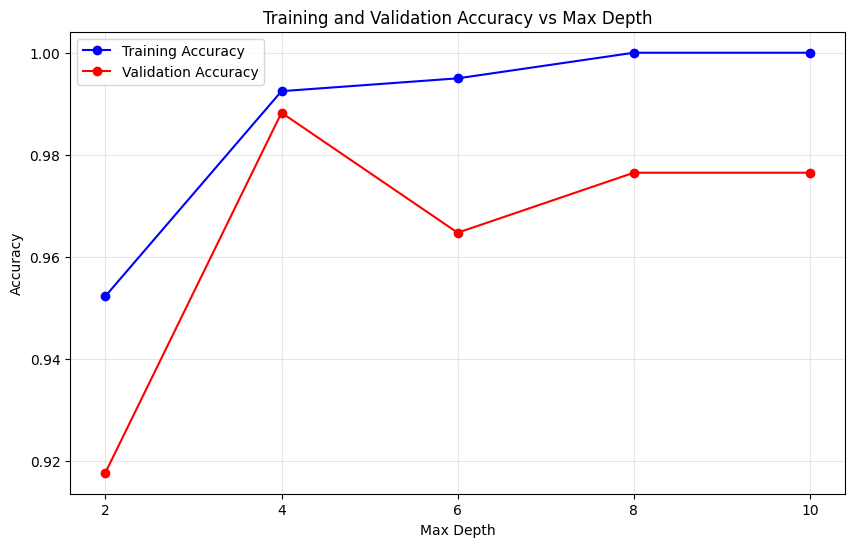

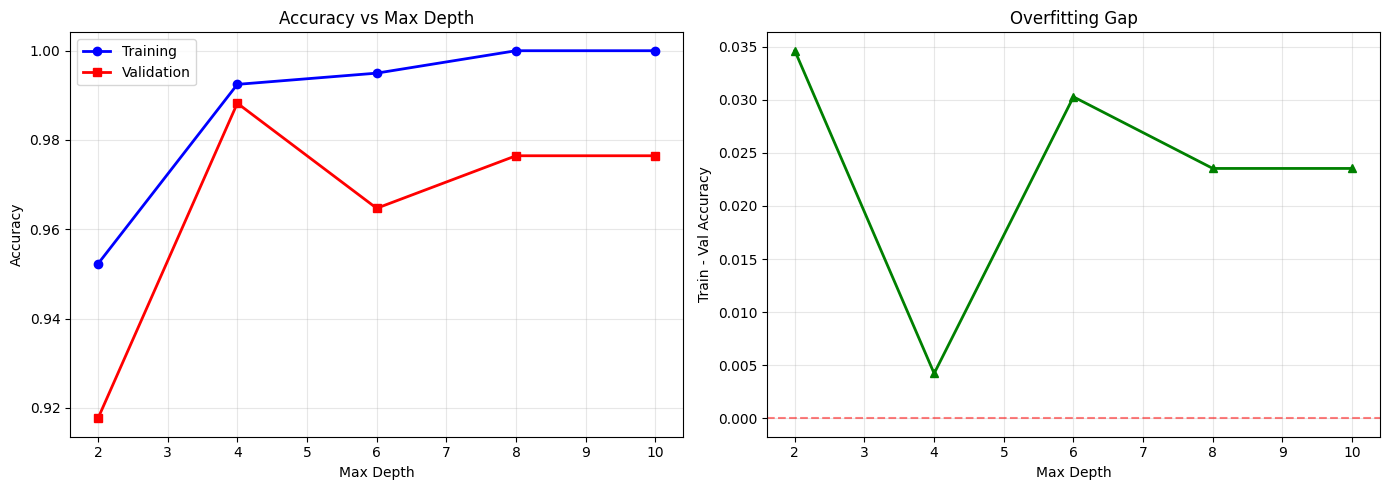

Final model performance on test set:
Best parameters: max_depth=4, min_samples_split=2
Test accuracy: 0.8837

TRAINING SET PERFORMANCE
Overall Accuracy: 0.9917

Class 0 (Malignant):
  Precision: 0.9944
  Recall:    0.9833
  F1-Score:  0.9888

Class 1 (Benign):
  Precision: 0.9902
  Recall:    0.9967
  F1-Score:  0.9934

VALIDATION SET PERFORMANCE
Overall Accuracy: 1.0000

Class 0 (Malignant):
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Class 1 (Benign):
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

TEST SET PERFORMANCE
Overall Accuracy: 0.8837

Class 0 (Malignant):
  Precision: 0.8667
  Recall:    0.8125
  F1-Score:  0.8387

Class 1 (Benign):
  Precision: 0.8929
  Recall:    0.9259
  F1-Score:  0.9091


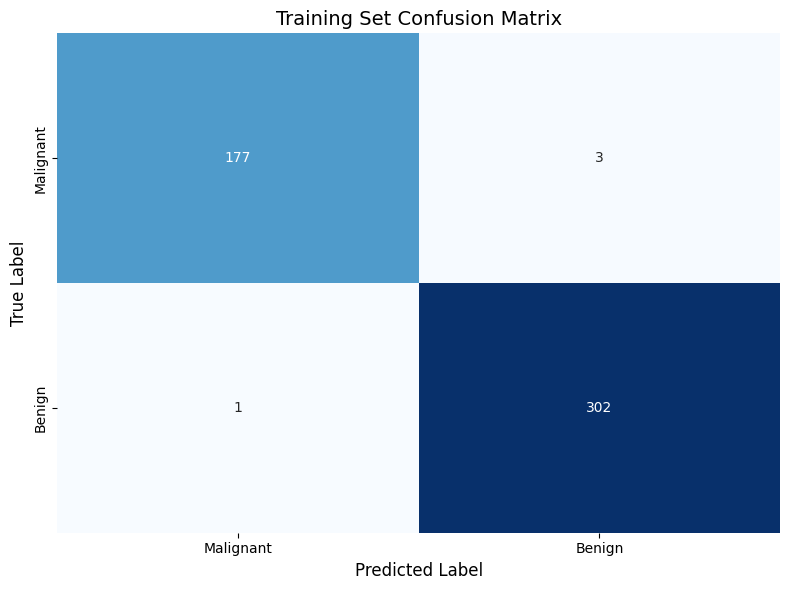

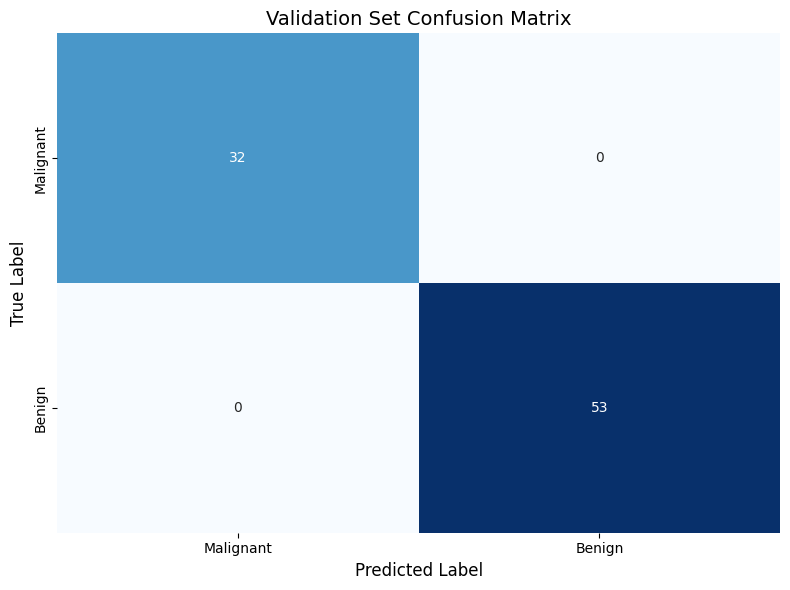

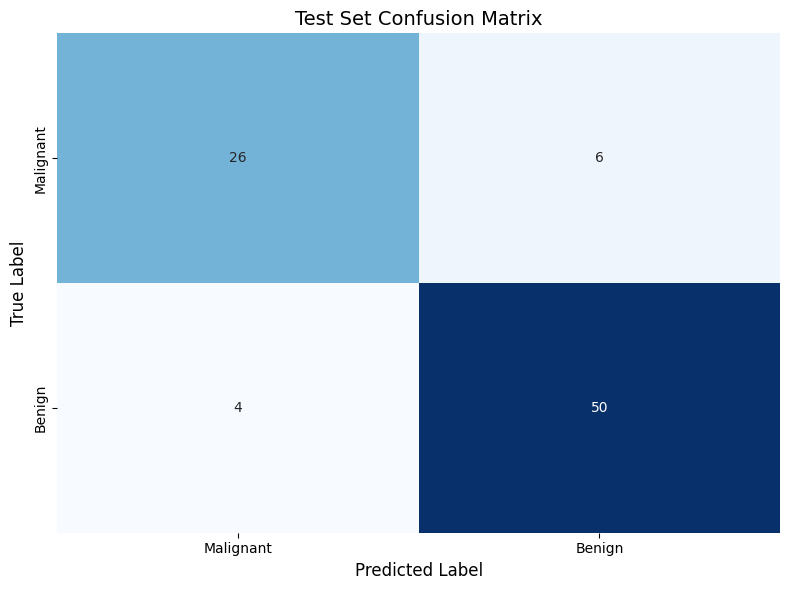

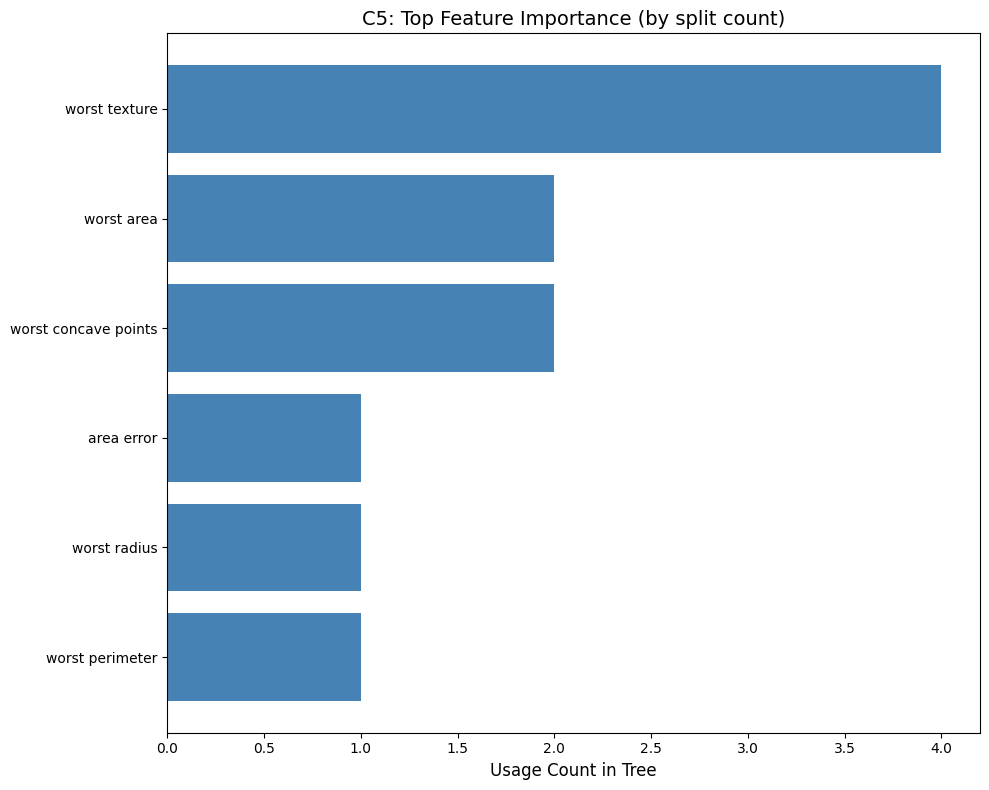


overfit
Using best single tree params:
  max_depth = 4
  min_samples_split = 2

Number of features in dataset: 30
Testing max_features: [5, 15] (sqrt(feats) and feats/2)




num_trees | max_features | Validation Accuracy




        5 |            5 | 0.9765              |
        5 |            5 | 0.9765              |
        5 |           15 | 0.9647              |
        5 |           15 | 0.9647              |
       10 |            5 | 0.9647              |
       10 |            5 | 0.9647              |
       10 |           15 | 0.9647              |
       10 |           15 | 0.9647              |
       30 |            5 | 0.9882              |
       30 |            5 | 0.9882              |
       30 |           15 | 1.0000              |
       30 |           15 | 1.0000              |
       50 |            5 | 0.9882              |
       50 |            5 | 0.9882              |
       50 |           15 | 1.0000              |




       50 |           15 | 1.0000  

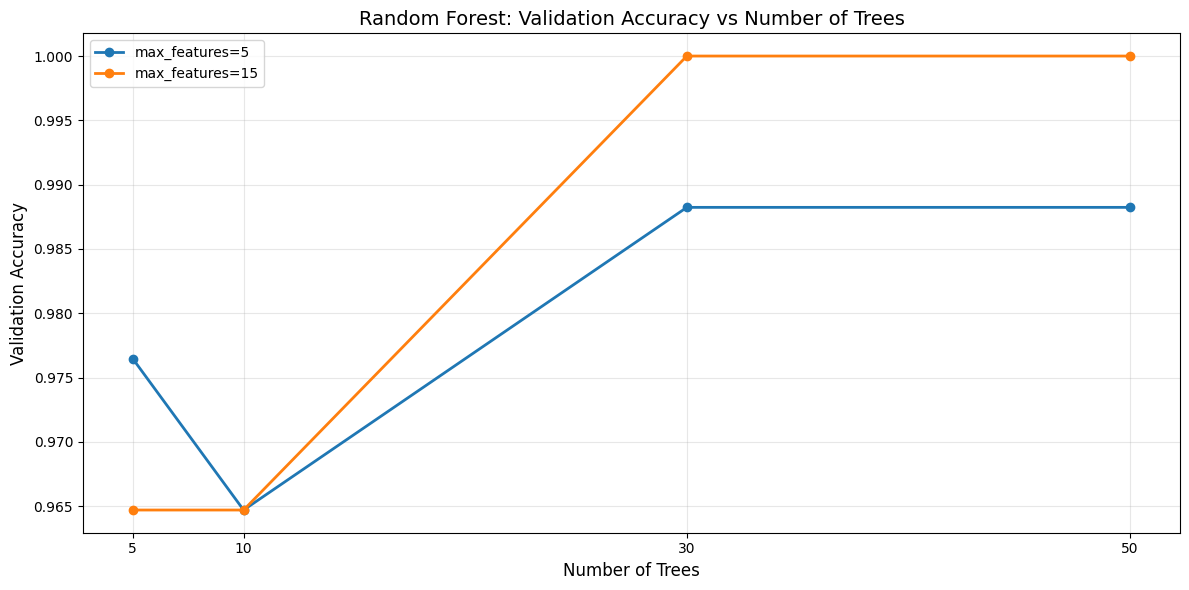

training random Forest with 30 trees

Single Decision Tree:
  Training Accuracy: 0.9917
  Test Accuracy:     0.8837

Random Forest:
  Training Accuracy: 0.9896
  Test Accuracy:     0.9070
  Test Accuracy Improvement: 0.0233
  Reduction in Overfitting:  0.0253

Random Forest achieves 2.33% better test accuracy

Single Decision Tree:
  Training Accuracy: 0.9917
  Test Accuracy:     0.8837

Random Forest:
  Training Accuracy: 0.9896
  Test Accuracy:     0.9070
  Test Accuracy Improvement: 0.0233
  Reduction in Overfitting:  0.0253

Random Forest achieves 2.33% better test accuracy


In [180]:
def load_and_split_data():    
    data = load_breast_cancer()
    X, y = data.data, data.target
    feature_names = data.feature_names
    
    # First split: 70% train, 30% temp (validation + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Second split: 50% of temp for validation, 50% for test (15% each of original)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test, feature_names

X_train, X_val, X_test, y_train, y_val, y_test, feature_names = load_and_split_data()


   
best_params, tuning_results = hyperparameter_tuning(X_train, y_train, X_val, y_val)
    
#Analyze depth vs accuracy with fixed min_samples_split    
max_depths, train_accuracies, val_accuracies = analyze_depth_vs_accuracy(
    X_train, y_train, X_val, y_val, fixed_min_samples_split=2
    )
    
    
plot_depth_vs_accuracy(max_depths, train_accuracies, val_accuracies)

#C5: Perform tree complexity analysis
complexity_results = analyze_tree_complexity(X_train, y_train, X_val, y_val, [2, 4, 6, 8, 10])
    
    #training + validation with best parameters and evaluate on test set  
    #Combine training and validation sets
X_train_val = np.vstack([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])
    
    # Train final model with best parameters
final_tree = DecisionTree(max_depth=best_params['max_depth'],min_samples_split=best_params['min_samples_split'])
final_tree.singleTreefit(X_train_val, y_train_val)
    
#evaluate the best tree params on test set
y_test_pred = final_tree.singleTreePredict(X_test)
test_accuracy = final_tree.accuracy(y_test, y_test_pred)
    
print(f"Final model performance on test set:")
print(f"Best parameters: max_depth={best_params['max_depth']}, "
          f"min_samples_split={best_params['min_samples_split']}")
print(f"Test accuracy: {test_accuracy:.4f}")

#C5: Perform comprehensive evaluation on final model
final_metrics = comprehensive_evaluation(
    final_tree, X_train_val, y_train_val, 
    X_val, y_val, X_test, y_test, feature_names
)
    
best_rf_params, rf_tuning_results = random_forest_hyperparameter_tuning(X_train, y_train, X_val, y_val, best_params)
    
plot_random_forest_results(rf_tuning_results)
    
compare_single_tree_vs_random_forest(X_train, y_train, X_val, y_val, X_test, y_test,best_params, best_rf_params)